# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Simmple RNN

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        classification_hidden_dim: int = 256,
        num_classes: int = 2,
        num_layers: int = 1,
        aggregation_type: str = 'max',
        bidirectional: bool = False,
        dropout: float = 0.0
        ):
        super().__init__()

        self.aggregation_type = aggregation_type
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        assert dropout < 1.0, "invalid dropout value"
        self.rnn = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim,
                          batch_first=True, num_layers=num_layers,
                          bidirectional=bidirectional, dropout=dropout)

        rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.classifier = nn.Sequential(nn.Linear(rnn_output_dim, classification_hidden_dim),
                                        nn.ReLU(),
                                        nn.Linear(classification_hidden_dim, num_classes))


    def forward(self, input_batch) -> torch.Tensor:
        d_mult = 1 if not self.bidirectional else 2
        batch_size = len(input_batch)
        h_0 = torch.zeros(d_mult * self.num_layers, batch_size, self.hidden_dim).to(device)

        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings, h_0)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        prediction = self.classifier(output)
        return prediction

### First model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 1,
aggregation_type = 'max',
bidirectional = False,
dropout = 0.0
"""
simple_rnn_01 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=1).to(device)

optimizer = torch.optim.Adam(simple_rnn_01.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
def model_training(model, optimizer, criterion) -> List[torch.Tensor]:
    loss_history = []

    for epoch in range(8):
        batch_losses = []
        for i, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            predicted = model.forward(batch['input_ids'].to(device)).cpu()
            loss = criterion(predicted, batch['label'].cpu())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.detach().numpy())

        loss_history.append(np.mean(np.asarray(batch_losses)))

    return loss_history

In [ ]:
simple_rnn_01.train()

model_01_history = model_training(simple_rnn_01, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Second model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 1,
aggregation_type = 'mean',
bidirectional = False,
dropout = 0.0
"""
simple_rnn_02 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=1,
                          aggregation_type = 'mean').to(device)

optimizer = torch.optim.Adam(simple_rnn_02.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
simple_rnn_02.train()

model_02_history = model_training(simple_rnn_02, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Third model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 3,
aggregation_type = 'mean',
bidirectional = False,
dropout = 0.0
"""
simple_rnn_03 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=1,
                          aggregation_type = 'mean').to(device)

optimizer = torch.optim.Adam(simple_rnn_03.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
simple_rnn_03.train()

model_03_history = model_training(simple_rnn_03, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Forth model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 5,
aggregation_type = 'mean',
bidirectional = False,
dropout = 0.0
"""
simple_rnn_04 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=1,
                          aggregation_type = 'mean').to(device)

optimizer = torch.optim.Adam(simple_rnn_04.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
simple_rnn_04.train()

model_04_history = model_training(simple_rnn_04, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Comparision

In [ ]:
def print_losses(losses):
    for (name, values), color in zip(losses.items(), ['red', 'blue', 'green', 'yellow', '']):
    # for name, values in losses.items():
        plt.plot(np.arange(len(losses[name])), losses[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

Creating Dict

In [ ]:
losses_history = {'model1': model_01_history,
                  'model2': model_02_history,
                  'model3': model_03_history,
                  'model4': model_04_history}

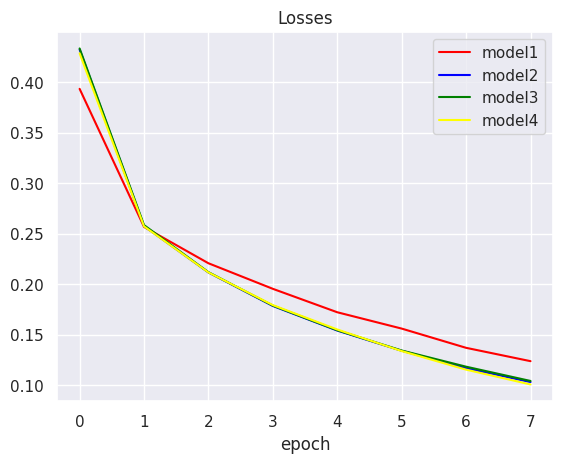

In [ ]:
print_losses(losses_history)

Такми образом, оптимальное количество слоев в RNN = 5, а aggregation_type = mean. Но, в целом, особой роли количество слоев не играет. Также сравним по метрике на валидационной выборке:


In [ ]:
print("Model1 accuraccy on validation dataset: ", evaluate(simple_rnn_01, eval_dataloader))
print("Model2 accuraccy on validation dataset: ", evaluate(simple_rnn_02, eval_dataloader))
print("Model3 accuraccy on validation dataset: ", evaluate(simple_rnn_03, eval_dataloader))
print("Model4 accuraccy on validation dataset: ", evaluate(simple_rnn_04, eval_dataloader))

Model1 accuraccy on validation dataset:  0.8973999619483948
Model2 accuraccy on validation dataset:  0.8999999761581421
Model3 accuraccy on validation dataset:  0.9034000039100647
Model4 accuraccy on validation dataset:  0.9034000039100647


Теперь подберем подходящее значение в dropout и посмотрим, справляется ли лучше сетка в режиме bidirectional.
## Fifth model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 5,
aggregation_type = 'mean',
bidirectional = True,
dropout = 0.0
"""
simple_rnn_05 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=5,
                          aggregation_type='mean',
                          bidirectional=True).to(device)

optimizer = torch.optim.Adam(simple_rnn_05.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
simple_rnn_05.train()

model_05_history = model_training(simple_rnn_05, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Sixth Model

In [ ]:
"""
hidden_dim = 256
classification_hidden_dim = 256,
num_classes = 4,
num_layers = 5,
aggregation_type = 'mean',
bidirectional = True,
dropout = 0.0
"""
simple_rnn_06 = SimpleRNN(hidden_dim=256,
                          vocab_size=len(vocab),
                          num_classes=4,
                          num_layers=5,
                          aggregation_type='mean',
                          bidirectional=True,
                          dropout=0.2).to(device)

optimizer = torch.optim.Adam(simple_rnn_06.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
simple_rnn_06.train()

model_06_history = model_training(simple_rnn_06, optimizer, criterion)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

### Comparision

In [ ]:
losses_history = {'model4': model_04_history,
                  'model5': model_05_history,
                  'model6': model_06_history}

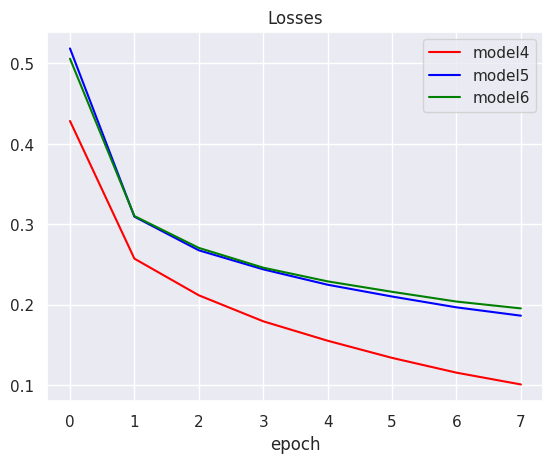

In [ ]:
print_losses(losses_history)

In [ ]:
print("Model 4 accuraccy on validation dataset: ", evaluate(simple_rnn_04, eval_dataloader))
print("Model 5 accuraccy on validation dataset: ", evaluate(simple_rnn_05, eval_dataloader))
print("Model 6 accuraccy on validation dataset: ", evaluate(simple_rnn_06, eval_dataloader))

Model 4 accuraccy on validation dataset:  0.9034000039100647
Model 5 accuraccy on validation dataset:  0.895799994468689
Model 6 accuraccy on validation dataset:  0.8937999606132507
